
# Video Inference Demo

This notebook demonstrates how to load a trained model and run inference on a video using `inference.py`.

In [ ]:
import torch
import os
import sys
import random
import glob
import matplotlib.pyplot as plt
from torchvision.io import read_video
import math
import time
import cv2
import numpy as np

project_dir = os.path.abspath('.')
if project_dir not in sys.path:
    sys.path.append(project_dir)

import config as cfg
from inference import load_inference_model, load_class_map, predict_video

In [ ]:
model_path = os.path.join('outputs', 'best_model.pth')  
class_map_path = os.path.join(cfg.DATA_FOLDER, 'new_class_map.json')
device = torch.device(cfg.DEVICE)

print(f"Model checkpoint: {model_path}")
print(f"Class map: {class_map_path}")
print(f"Device: {device}")

Model checkpoint: outputs/best_model.pth
Class map: datasets/TinyVIRAT_V2/new_class_map.json
Device: cpu


In [ ]:
model = load_inference_model(model_path, device)
class_map = load_class_map(class_map_path)
print(f"Loaded {len(class_map)} classes.")

index_to_name = {}
try:
    first_key = next(iter(class_map.keys()))
    int(first_key) 
    index_to_name = class_map 
    print("Debug: class_map format appears correct {'Index': 'Name'}.")
except (ValueError, StopIteration):
    print("Debug: class_map format appears inverted {'Name': 'Index'}, creating index_to_name map.")
    index_to_name = {v: k for k, v in class_map.items()}
except Exception as e:
    print(f"Debug: Error determining class_map format: {e}. Assuming {'Index': 'Name'}.")
    index_to_name = class_map 

Generating model structure for inference (pretrained weights will be loaded from checkpoint)...
Generating torchvision model: r2plus1d_18
Loading model with random weights.
Original classifier input features: 512
Replaced final classifier (fc) with 512 input features and 9 output classes (from config.py).
Loading trained weights from checkpoint: outputs/best_model.pth
Original classifier input features: 512
Replaced final classifier (fc) with 512 input features and 9 output classes (from config.py).
Loading trained weights from checkpoint: outputs/best_model.pth
Trained model loaded successfully for inference.
Loaded 9 classes.
Debug: class_map format appears inverted {'Name': 'Index'}, creating index_to_name map.
Trained model loaded successfully for inference.
Loaded 9 classes.
Debug: class_map format appears inverted {'Name': 'Index'}, creating index_to_name map.


In [ ]:
video_path = 'datasets/TinyVIRAT_V2/videos/test/01222.mp4'  
assert os.path.exists(video_path), f"Video file not found: {video_path}"

In [ ]:
start_time = time.perf_counter()
predictions = predict_video(model, video_path, class_map, device=device, threshold=0.5)
end_time = time.perf_counter()
inference_duration = end_time - start_time

print(f"Inference took {inference_duration:.3f} seconds for the single video.")
print("\nPredicted classes (probability >= 0.5) for the single video:")

index_to_name = {}
try:
    first_key = next(iter(class_map.keys()))
    int(first_key) 
    index_to_name = class_map 
except (ValueError, StopIteration):
    index_to_name = {v: k for k, v in class_map.items()}
except Exception as e:
    print(f"Debug: Error determining class_map format: {e}. Assuming {'Index': 'Name'}.")
    index_to_name = class_map 

if predictions:
    for class_idx_str, prob in predictions.items():
        class_name = index_to_name.get(class_idx_str, f"Unknown Index {class_idx_str}")
        print(f"  {class_name}: {prob:.3f}")
else:
    print("No classes predicted above threshold for the single video.")

Inference took 0.532 seconds for the single video.

Predicted classes (probability >= 0.5) for the single video:
  activity_standing: 0.990


## Display Sample Frames

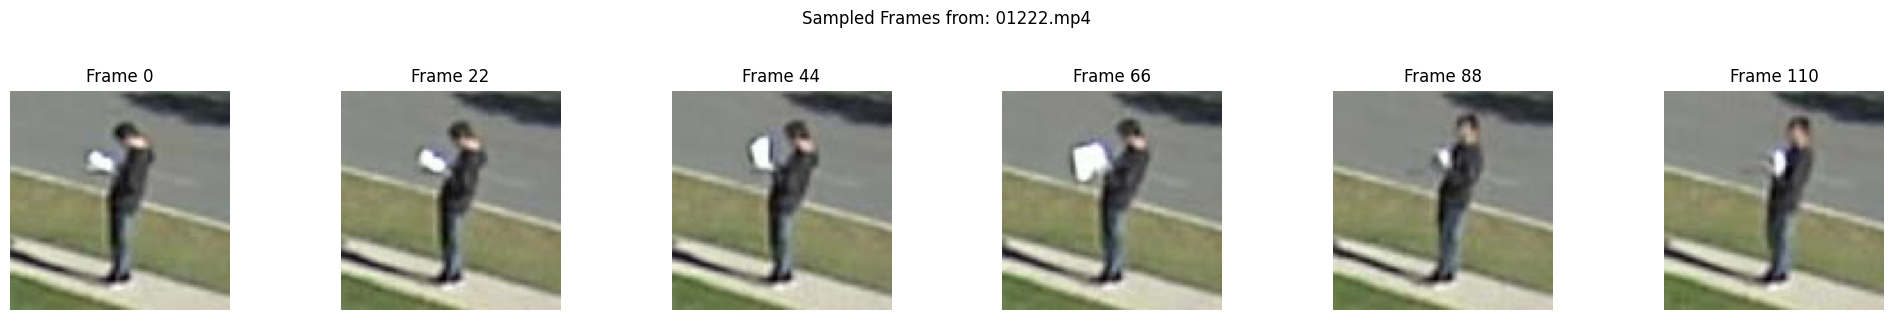

In [48]:
import matplotlib.pyplot as plt
from torchvision.io import read_video
import math

# Load video frames (T, H, W, C)
frames, _, _ = read_video(video_path, pts_unit='sec', output_format="THWC")
total_frames = frames.shape[0]
num_display_frames = 6

# Select frames to display
indices = torch.linspace(0, total_frames - 1, num_display_frames, dtype=torch.long)
sampled_frames = frames[indices]

# Display frames
fig, axes = plt.subplots(1, num_display_frames, figsize=(20, 3))
fig.suptitle(f'Sampled Frames from: {os.path.basename(video_path)}', y=1.05)
for i, frame in enumerate(sampled_frames):
    ax = axes[i]
    ax.imshow(frame.numpy())
    ax.set_title(f'Frame {indices[i].item()}')
    ax.axis('off')
plt.tight_layout()
plt.show()

## Run Inference on Random Test Videos

In [49]:
def run_inference_on_random_videos(model, class_map, index_to_name_map, device, num_videos=5, test_folder='datasets/TinyVIRAT_V2/videos/test', num_display_frames=6, threshold=0.5):
    """Runs inference on random videos from the test set, measures time, and displays results."""
    video_files = glob.glob(os.path.join(test_folder, '*.mp4'))
    if not video_files:
        print(f"Error: No video files found in {test_folder}")
        return

    selected_videos = random.sample(video_files, min(num_videos, len(video_files)))
    total_inference_time = 0.0
    processed_video_count = 0

    for video_path in selected_videos:
        print(f"\n--- Processing Video: {os.path.basename(video_path)} ---")

        # Run inference and measure time
        start_time = time.perf_counter()
        predictions = predict_video(model, video_path, class_map, device=device, threshold=threshold)
        end_time = time.perf_counter()
        inference_duration = end_time - start_time
        total_inference_time += inference_duration
        processed_video_count += 1

        print(f"  Inference took: {inference_duration:.3f} seconds")

        # Only print header and predictions once per video
        if predictions:
            print("  Predicted classes (probability >= 0.5):")
            for class_idx_str, prob in predictions.items():
                class_name = index_to_name_map.get(class_idx_str, f"Unknown Index {class_idx_str}")
                print(f"    {class_name}: {prob:.3f}")
        else:
            print("  No classes predicted above threshold.")

        # Display frames
        try:
            frames, _, _ = read_video(video_path, pts_unit='sec', output_format="THWC")
            total_frames = frames.shape[0]
            if total_frames == 0:
                print("  Skipping frame display: Video has no frames.")
                continue

            indices = torch.linspace(0, total_frames - 1, num_display_frames, dtype=torch.long)
            sampled_frames = frames[indices]

            fig, axes = plt.subplots(1, num_display_frames, figsize=(20, 3))
            fig.suptitle(f'Sampled Frames from: {os.path.basename(video_path)}', y=1.02)
            for i, frame in enumerate(sampled_frames):
                ax = axes[i]
                ax.imshow(frame.numpy())
                ax.set_title(f'Frame {indices[i].item()}')
                ax.axis('off')
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"  Error displaying frames for {os.path.basename(video_path)}: {e}")
        print("-----------------------------------------")

    if processed_video_count > 0:
        average_time = total_inference_time / processed_video_count
        print(f"\nAverage inference time over {processed_video_count} videos: {average_time:.3f} seconds")


--- Processing Video: 02413.mp4 ---
  Inference took: 0.548 seconds
  No classes predicted above threshold.
  Inference took: 0.548 seconds
  No classes predicted above threshold.


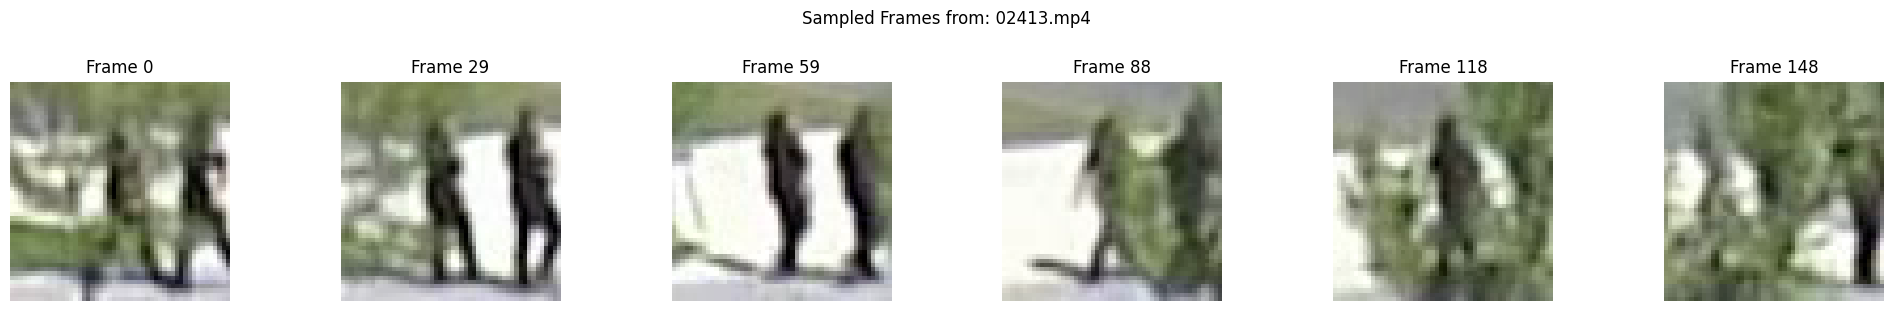

-----------------------------------------

--- Processing Video: 03310.mp4 ---
  Inference took: 0.361 seconds
  Predicted classes (probability >= 0.5):
    Interacts: 0.712
    activity_standing: 0.906
  Inference took: 0.361 seconds
  Predicted classes (probability >= 0.5):
    Interacts: 0.712
    activity_standing: 0.906


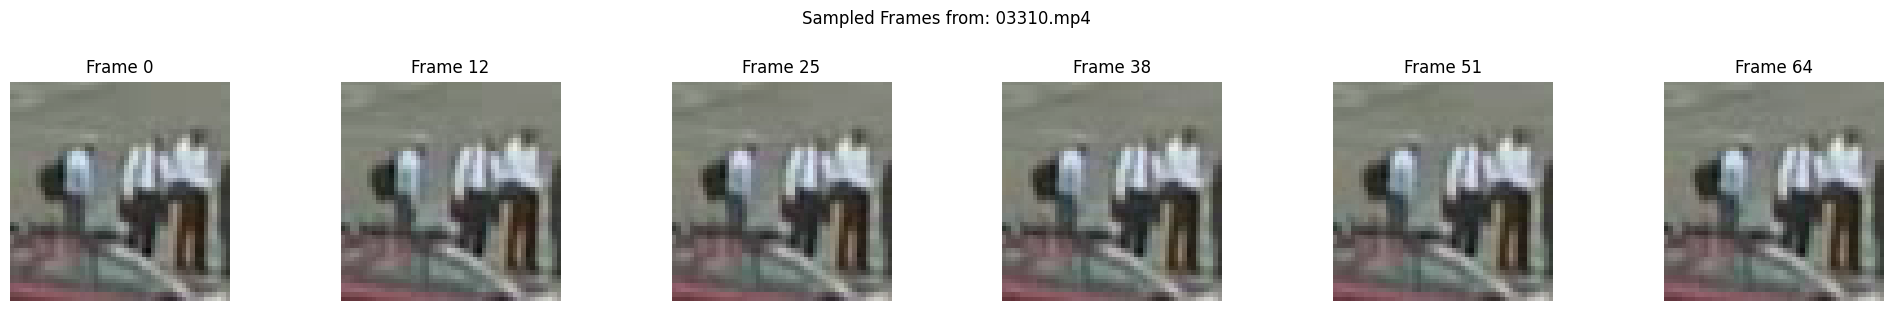

-----------------------------------------

--- Processing Video: 03499.mp4 ---
  Inference took: 0.336 seconds
  Predicted classes (probability >= 0.5):
    activity_walking: 0.999
  Inference took: 0.336 seconds
  Predicted classes (probability >= 0.5):
    activity_walking: 0.999


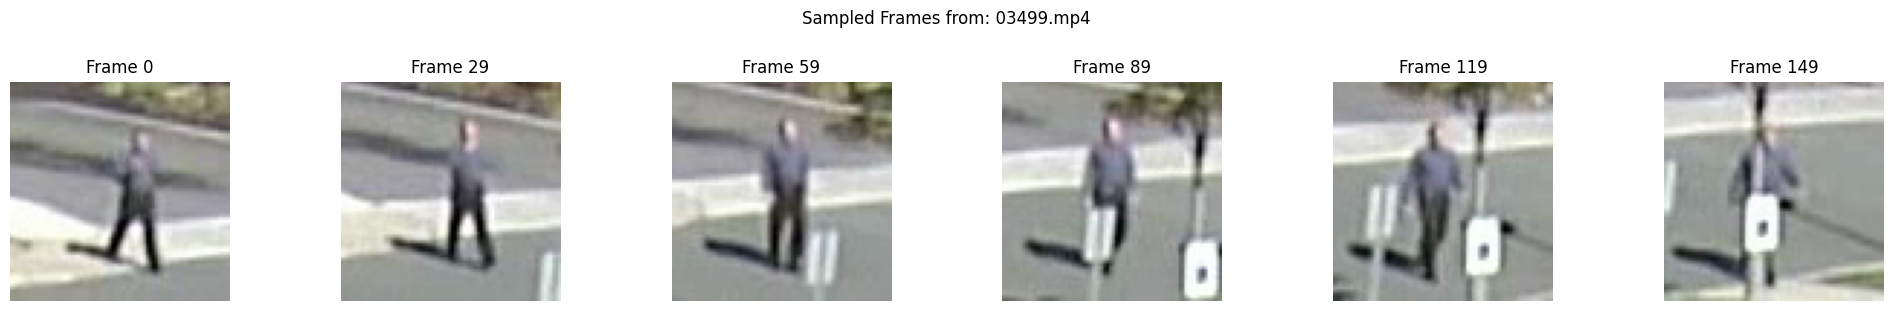

-----------------------------------------

--- Processing Video: 00280.mp4 ---
  Inference took: 0.307 seconds
  Predicted classes (probability >= 0.5):
    activity_walking: 0.572
  Inference took: 0.307 seconds
  Predicted classes (probability >= 0.5):
    activity_walking: 0.572


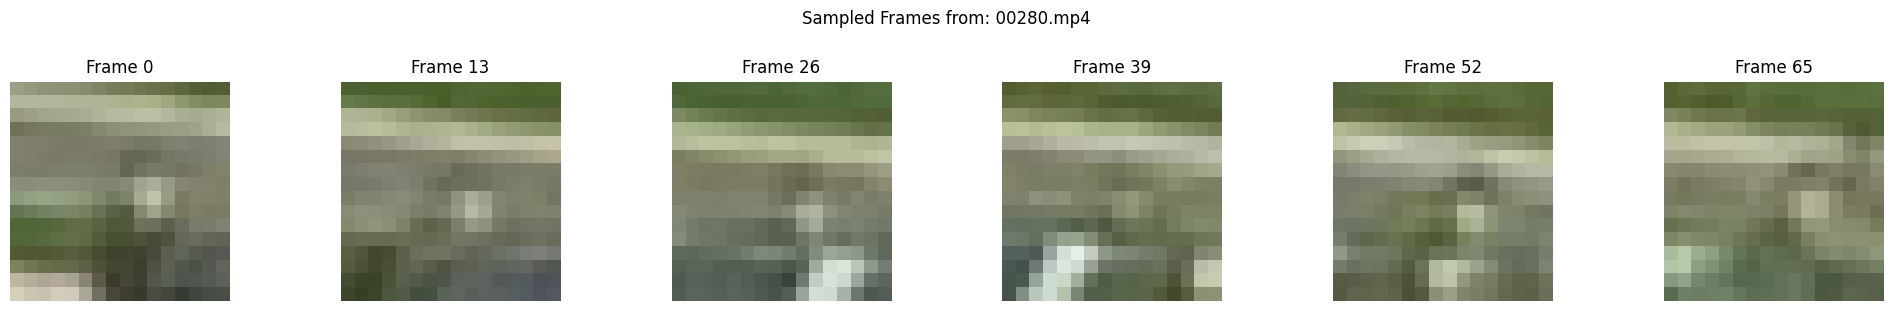

-----------------------------------------

--- Processing Video: 04368.mp4 ---
  Inference took: 0.380 seconds
  Predicted classes (probability >= 0.5):
    vehicle_moving: 1.000
  Inference took: 0.380 seconds
  Predicted classes (probability >= 0.5):
    vehicle_moving: 1.000


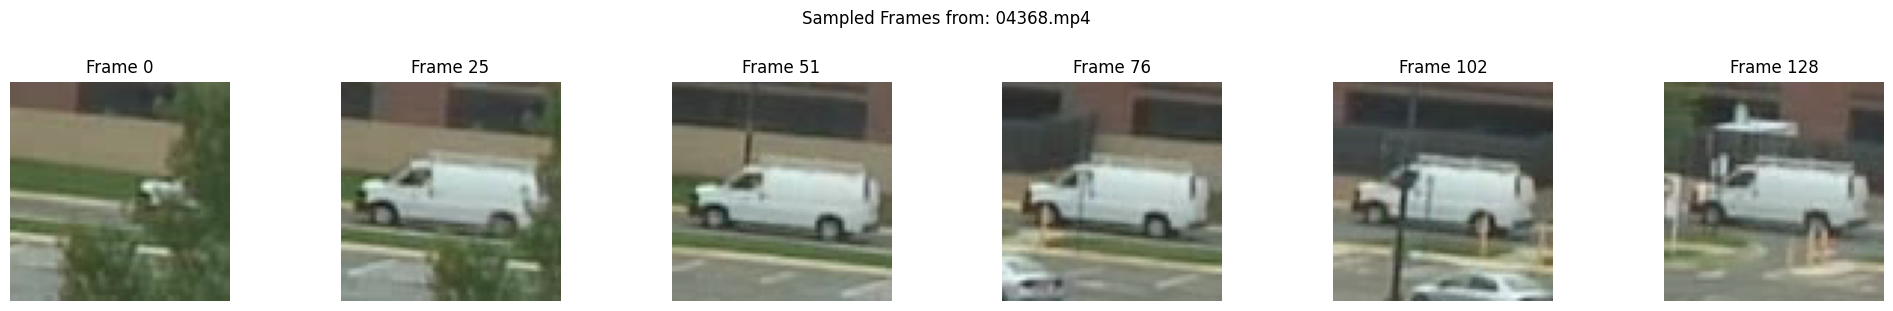

-----------------------------------------

Average inference time over 5 videos: 0.386 seconds


In [ ]:
run_inference_on_random_videos(model, class_map, index_to_name, device, num_videos=5)

In [ ]:
def get_top_label(predictions, index_to_name):
    if not predictions:
        return None, None
    class_idx_str, prob = max(predictions.items(), key=lambda x: x[1])
    class_name = index_to_name.get(class_idx_str, f"Unknown {class_idx_str}")
    return class_name, prob

def add_label_below_frame(frame, label, prob, out_w, label_h=36, font_scale=0.64):
    """Adds a label/probability below the frame, outside the video area."""
    label_text = f"{label}: {prob:.2f}" if label is not None else "No prediction"
    font = cv2.FONT_HERSHEY_SIMPLEX
    color = (255, 255, 255)
    thickness = 1
    # Convert frame to uint8 np.array (H,W,C)
    if isinstance(frame, np.ndarray):
        img = frame.copy()
    else:
        img = frame.numpy().copy()
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    # Ensure 3 channels
    if img.shape[-1] == 1:
        img = np.repeat(img, 3, axis=-1)
    h, w = img.shape[:2]
    # Pad width if needed
    if w < out_w:
        pad_left = (out_w - w) // 2
        pad_right = out_w - w - pad_left
        img = cv2.copyMakeBorder(img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=(0,0,0))
    # Add label area below
    label_img = np.zeros((label_h, out_w, 3), dtype=np.uint8)
    (text_w, text_h), _ = cv2.getTextSize(label_text, font, font_scale, thickness)
    text_x = 8
    text_y = label_h // 2 + text_h // 2
    cv2.putText(label_img, label_text, (text_x, text_y), font, font_scale, color, thickness, cv2.LINE_AA)
    out_img = np.vstack([img, label_img])
    return out_img

def concat_videos_with_padding(video_paths, model, class_map, index_to_name, device, num_frames=32, pad_frames=8, output_path='concatenated_test_videos.mp4', threshold=0.5, resize_to=(512, 512)):
    """Loads N videos, runs inference, resizes, and concatenates them with padding and labels below the video."""
    clips = []
    heights = []
    widths = []
    fps_list = []
    label_h = 36  # Height for label area below video (2x previous)
    for video_path in video_paths:
        frames, _, info = read_video(video_path, pts_unit='sec', output_format="THWC")
        fps = info.get('video_fps', 15)
        fps_list.append(fps)
        total_frames = frames.shape[0]
        if total_frames < num_frames:
            indices = np.linspace(0, total_frames-1, total_frames, dtype=int)
        else:
            indices = np.linspace(0, total_frames-1, num_frames, dtype=int)
        sampled_frames = frames[indices]
        # Resize frames to resize_to (e.g., 512x512)
        resized_frames = [cv2.resize(f.numpy() if hasattr(f, 'numpy') else f, resize_to, interpolation=cv2.INTER_LINEAR) for f in sampled_frames]
        predictions = predict_video(model, video_path, class_map, device=device, threshold=threshold)
        label, prob = get_top_label(predictions, index_to_name)
        heights.append(resize_to[1])
        widths.append(resize_to[0])
        clips.append((resized_frames, label, prob))

    out_h = max(heights)
    out_w = max(widths)
    total_h = out_h + label_h

    # Pad all frames to same size and add label below
    padded_clips = []
    for frames, label, prob in clips:
        padded = []
        for f in frames:
            h, w = f.shape[:2]
            pad_h = out_h - h
            pad_w = out_w - w
            top = pad_h // 2
            bottom = pad_h - top
            left = pad_w // 2
            right = pad_w - left
            f_padded = cv2.copyMakeBorder(f, top, bottom, left, right, cv2.BORDER_CONSTANT, value=(0,0,0))
            f_labeled = add_label_below_frame(f_padded, label, prob, out_w, label_h=label_h, font_scale=0.64)
            padded.append(f_labeled)
        padded_clips.append(padded)

    # Create black frames for padding between clips
    pad_frame = np.zeros((total_h, out_w, 3), dtype=np.uint8)
    pad_clip = [pad_frame.copy() for _ in range(pad_frames)]

    # Concatenate all clips with padding
    concat_frames = []
    for i, clip in enumerate(padded_clips):
        concat_frames.extend(clip)
        if i < len(padded_clips)-1:
            concat_frames.extend(pad_clip)

    out_fps = int(np.median(fps_list)) if fps_list else 15
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, out_fps, (out_w, total_h))
    for f in concat_frames:
        out.write(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
    out.release()
    print(f"Saved concatenated video to {output_path}")



test_folder = 'datasets/TinyVIRAT_V2/videos/test'
video_files = glob.glob(os.path.join(test_folder, '*.mp4'))
selected_videos = random.sample(video_files, min(20, len(video_files)))
concat_videos_with_padding(selected_videos, model, class_map, index_to_name, device, num_frames=32, pad_frames=8, output_path='concatenated_test_videos4.mp4', threshold=0.5, resize_to=(512, 512))

Saved concatenated video to concatenated_test_videos4.mp4
